In [63]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Created on Tue Mar 14 14:47:58 2023

@author: mariapopovic
"""

from numpy import array, exp, append, linspace, log, average, around, arange, sqrt, random, inf
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from math import erf, pi, erfc
from scipy.special import erfinv
from scipy.stats import norm
from statistics import mean, stdev
from sklearn.metrics import mean_absolute_error

<BarContainer object of 64 artists>

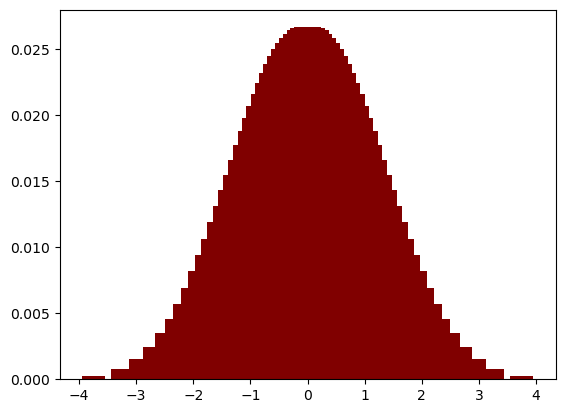

In [64]:
### Load data from files generated with Mathematica ###

n = [4,5,6,7,8,9,10,11]
probabilities_stationary = []
gammas = []
number_bins_list = []
number_bins_str = []

index = 0
for el in n:
    number_bins_list.append(2*(2**int(el)))
    number_bins_str.append(str(number_bins_list[index]))
    index = index + 1

for el in number_bins_str:
    prob = []
    gam = []
          
    f1=open("probabilities_NBins_" + el + ".txt", "r")

    if f1.mode == 'r':
        t=f1.readlines()

    for index in t:
        
        prob.append(float(index.replace('\n','')))
       
    f2=open("gammas_NBins_"+el+".txt", "r")

    if f2.mode == 'r':
        g=f2.readlines()

    for index in g:
        gam.append(float(index.replace('\n','')))
      
    
    gammas.append(gam)
    probabilities_stationary.append(prob)

# Plots one example, in this case for 2^3 bins

#plt.bar(gammas[1], probabilities_stationary[1], color ='maroon', width=0.4)

# Linear quantizers

In [105]:
### Create linear quantizers in equal length intervals with corresponding CDFs ###
    

# Initiate lists: each elemement will also be a list corresponding to 2^2 number of bins, 2^3, 2^4 etc

knots_linear = []
extreme_cell_bounds = []
cell_bounds_linear = []
cdf_linear_rightbound = []

for index in range(0,len(number_bins_list)):
    
    # Create knots for linear quantizers from the gamma functions
    
    kl = linspace(gammas[index][0], gammas[index][-1], number_bins_list[index])
    knots_linear.append(kl)        

    # Fix the two extreme points for the interval in which the cells are located: the extreme Voronoi cells are
    # unbounded, so we bound them by taking the value after the marginal knots for which the standard normal has less
    # than 1% probability
    
    j = 0.8
    guess = round(gammas[index][0]) - j
    normal_distribution = norm(0,1).pdf(guess)
    
    while normal_distribution >= 0.01:
        j = j + 0.2
        guess = round(gammas[index][0]) - j
        normal_distribution = norm(0,1).pdf(guess)
        
    extreme_cell_bounds.append([norm.ppf(normal_distribution), norm.ppf(1 - normal_distribution)])

    # Append extreme left bound

    cell_bounds_linear.append([extreme_cell_bounds[index][0]])
    
    for index2 in range(1,len(knots_linear[index])):
    
        cell_bounds_linear[index].append((knots_linear[index][index2] + knots_linear[index][index2 - 1])/2)
        
    # Append extreme right bound
    
    cell_bounds_linear[index].append(extreme_cell_bounds[index][1])
    
    # Define the cumulative distribution function from the right extreme of each cell

    cdf_linear_rightbound.append(norm.cdf(cell_bounds_linear[index][1:]))
    
    # Round last element to = 1

    tmp = cdf_linear_rightbound[index][:-1]
    cdf_linear_rightbound[index] = append(tmp,round(cdf_linear_rightbound[index][-1]))
    
    #knots_linear[index] = around(knots_linear[index],5)
    #cdf_linear_rightbound[index] = around(cdf_linear_rightbound[index],5)


# Stationary quantizers

In [106]:
### Create stationary quantizers ###

knots_stationary = []
cell_bounds_stationary = []
cdf_stationary_rightbound = []

for index in range(0,len(number_bins_list)):

    # The stationary knots are just the gammas that solve the system of equations

    knots_stationary = gammas
    
    # Append extreme left bound, which is the same as the linear case
    
    cell_bounds_stationary.append([extreme_cell_bounds[index][0]])
    
    for index2 in range(1,len(knots_stationary[index])):
    
        cell_bounds_stationary[index].append((knots_stationary[index][index2] + knots_stationary[index][index2 - 1])/2)
        
    # Append extreme right bound
    
    cell_bounds_stationary[index].append(extreme_cell_bounds[index][1])
    
    # Define the cumulative distribution function from the right extreme of each cell

    cdf_stationary_rightbound.append(norm.cdf(cell_bounds_stationary[index][1:]))

    # Round last element to = 1
    
    tmp = cdf_stationary_rightbound[index][:-1]
    cdf_stationary_rightbound[index] = append(tmp,round(cdf_stationary_rightbound[index][-1]))
    
    #knots_stationary[index] = around(knots_stationary[index],5)
    #cdf_stationary_rightbound[index] = around(cdf_stationary_rightbound[index],5)



# Equimass quantizer

In [107]:
### Create equi-mass quantizers ###

probabilities_equimass = [[]]*len(number_bins_list)
knots_equimass = []
cell_bounds_equimass = [[]]*len(number_bins_list)
cdf_equimass_rightbound = []


# Define inverse error function "erf" for calculations

def inverse_cdf(y):
    return sqrt(2)*erfinv(2*y - 1)

# Probabilities for equi-mass quantizer, same for every knot

for index_bin in range(0,len(number_bins_list)):
    
    el = number_bins_list[index_bin];
    probabilities_equimass[index_bin] = append(probabilities_equimass[index_bin], [1/el]*el)
    
# Create knots for equi-mass quantizer

for n in number_bins_list:
    
    gammas_equimass = []
    
    for i in range(1, n + 1):
        
        num_i = exp(-((inverse_cdf((i-1)/n))**2)/2) - exp(-((inverse_cdf(i/n))**2)/2)
        gamma_i = (n/(sqrt(2*pi)))*(num_i)
        gammas_equimass.append(gamma_i)
     
    knots_equimass.append(gammas_equimass)

    
# Create bounds for cells

for index_bin in range(0,len(number_bins_list)):
    
    n = number_bins_list[index_bin]
       
    for i in range(0, n+1):
        cell_bounds_equimass[index_bin] = append(cell_bounds_equimass[index_bin],inverse_cdf(i/n))

    

# Define the cumulative distribution function from the right extreme of each cell

for index_bin in range(0,len(number_bins_list)):
    cdf_equimass_rightbound.append(norm.cdf(cell_bounds_equimass[index_bin][1:]))
    
# Round last element to = 1

for index_bin in range(0,len(number_bins_list)):
    
    tmp = cdf_equimass_rightbound[index_bin][:-1]
    cdf_equimass_rightbound[index_bin] = append(tmp,round(cdf_equimass_rightbound[index_bin][-1]))
    

# Yearly returns data upload

In [108]:
### Load data time series ###

import pandas as pd

file = pd.read_excel('Backtest_Validation_Hist.xlsx',sheet_name='Daily returns')

data_daily = file['YIELDCURVE.EUR-MSWAP.ZERO.EUR(T365)'].tolist()

file2 = pd.read_excel('Backtest_Validation_Hist.xlsx',sheet_name='TS')

data = file2['YIELDCURVE.EUR-MSWAP.ZERO.EUR(T365)'].tolist()

data_initial_rate = []
data_yearly = []
index = 0
while (index + 251) < len(data_daily):
    data_initial_rate.append(data[index])
    data_yearly.append(sum(data_daily[index:index + 251]))
    index = index + 5
    


# Metropolis-Hastings function

In [109]:
# Define Metropolis-Hastings function

def metropolis_hastings(func, par_prev, func_next, par_next):
    # Cost function between the calculated Hull-White data and the real data
    

    cost_function = mean_absolute_error(func,data_yearly)
    cost_function_next = mean_absolute_error(func_next,data_yearly)


    acceptance_probability = min(1,exp((cost_function - cost_function_next)))
    
    x = random.uniform(0,1)
    
    if x < acceptance_probability:
        
        parameters_new = par_next
        
        func_new = func_next
        #print('Accepted')
        
    else:
        
        parameters_new = par_prev
        
        func_new = func
        #print('Rejected')
        
    return func_new, parameters_new

# Two-Factor Hull-White function

In [110]:
### Hull-White function ###

# Set initial values for t = 0
u_0 = 0 # Initial value for u


# Initialize the time lists
dt = 1 # One year
N = len(data_yearly)


def two_factor_hull_white(y1,y2,theta,a,b,sigma1,sigma2,r_prev,u_prev):
    
    u_next = (u_prev + sigma2*y2)/(1+b*dt)
    
    r_next = (r_prev + (theta + u_next)*dt + sigma1*y1)/(1+a*dt)
    
    dr = r_next - r_prev
    
    return r_next, u_next, dr

# Calibration of HW model with normal distribution parameters sampling

In [129]:
### Calibrate the Hull-White model constants against the real data, using normal distrubtion sampling ###
# For example, alpha, b, sigma1 and sigma2, theta, rho ignoring the time dependence

total_runs = 100

# Save the optimized parameters for all your runs
parameters_normal_runs = [[]]*total_runs

# Choose maximum error
precision = 0.1

# Save number of steps to precision for every run
iterations_normaldistr_runs = []


dimension = 6 # Number of parameters to sample


for index_runs in range(0,total_runs):
    
    parameters_normal = [] #parameters_normal = [a, b, theta, sigma1, sigma2, rho]
    iterations_to_precision_normaldistr = 0 
    
    # Initialize parameters that we need to calibrate


    # a

    x = random.normal(0,1)
    while x < 0:
        x = random.normal(0,1)
    parameters_normal.append(x)

    # b

    x = random.normal(0,1)
    #while x < 0:
        #x = random.normal(0,1)
    parameters_normal.append(x)

    # theta

    x = random.normal(0,1)
    while x < 0:
        x = random.normal(0,1)
    parameters_normal.append(x)

    # sigma1  > 0
    
    x = random.normal(0,1)
    while x < 0:
        x = random.normal(0,1)
    parameters_normal.append(x)

    
    # sigma2  > 0
    
    x = random.normal(0,1)
    while x < 0:
        x = random.normal(0,1)
    parameters_normal.append(x)


    # rho
    x = random.normal(0,1)
    #while x < 0:
        #x = random.normal(0,1)
    parameters_normal.append(x)


# Initialize Hull-White

    dr_list = []

    a_0 = parameters_normal[0]
    b_0 = parameters_normal[1]
    theta_0 = parameters_normal[2]
    sigma1_0 = parameters_normal[3]
    sigma2_0 = parameters_normal[4]
    rho_0 = parameters_normal[5]

    for index in range(0, N):

        wt = random.normal(0,dt)
        wt2 = (rho_0*dt)/wt
        hw_result = two_factor_hull_white(wt,wt2,a_0,b_0,theta_0,sigma1_0,sigma2_0,data_initial_rate[index],u_0)

        dr_list.append(hw_result[2])

    

    while mean_absolute_error(dr_list,data_yearly) > precision:
    
        iterations_to_precision_normaldistr = iterations_to_precision_normaldistr + 1

        # Generate next step parameters
        parameters_normal_next = []
    

        count_dim = 0
    
        # a>0, because it defines the long term mean variance sigma^2/(2 a) in the Vasicek model
        x =  random.normal(0,1)  # + parameters_normal[count_dim]
        
        while x < 0:
            x = random.normal(0,1)  # + parameters_normal[count_dim]
        
        parameters_normal_next.append(x)
        count_dim = count_dim + 1
    
        # b
        x = random.normal(0,1)  # + parameters_normal[count_dim]
        #while x < 0:
            #x = random.normal(0,1)  # + parameters_normal[count_dim])
        parameters_normal_next.append(x)
        count_dim = count_dim + 1
        
        # theta
        x = random.normal(0,1)  # + parameters_normal[count_dim]
        while x < 0:
            x = random.normal(0,1)  # + parameters_normal[count_dim]
        parameters_normal_next.append(x)
        count_dim = count_dim + 1
    
        # sigma1 > 0 
        x = random.normal(0,1)  # + parameters_normal[count_dim]
        while x < 0:
            x = random.normal(0,1)  # + parameters_normal[count_dim]
        parameters_normal_next.append(x)
        count_dim = count_dim + 1
            
        #sigma2 > 0
        x = random.normal(0,1)  # + parameters_normal[count_dim]
        while x < 0:
            x = random.normal(0,1)  # + parameters_normal[count_dim]
        parameters_normal_next.append(x)
        count_dim = count_dim + 1
    
        # rho
        x = random.normal(0,1)  # + parameters_normal[count_dim]
        #while x < 0:
            #x = parameters_normal[count_dim] + random.normal(0,1)
        parameters_normal_next.append(x)
        count_dim = count_dim + 1
    
    
        a_next = parameters_normal_next[0]
        b_next = parameters_normal_next[1]
        theta_next = parameters_normal_next[2]
        sigma1_next = parameters_normal_next[3]
        sigma2_next = parameters_normal_next[4]
        rho_next = parameters_normal_next[5]

    
        # Generate new proposed step in random walk

        dr_list_next = []
  

        for index in range(0,N):

            wt = random.normal(0,dt)
            wt2 = (rho_next*dt)/wt
            hw_result = two_factor_hull_white(wt,wt2,a_next,b_next,theta_next,sigma1_next,sigma2_next,data_initial_rate[index],u_0)
            dr_list_next.append(hw_result[2])
    
        

        dr_list, parameters_normal = metropolis_hastings(dr_list, parameters_normal, dr_list_next, parameters_normal_next)

    iterations_normaldistr_runs.append(iterations_to_precision_normaldistr)
    parameters_normal_runs[index_runs] = append(parameters_normal_runs[index_runs], parameters_normal)
    
    

In [130]:
## Averages, standard errors, plots

a_list = []
b_list = []
theta_list = []
sigma1_list = []
sigma2_list = []
rho_list = []
 
for index_runs in range(0,total_runs):
    
    a_list.append(parameters_normal_runs[index_runs][0])
    b_list.append(parameters_normal_runs[index_runs][1])
    theta_list.append(parameters_normal_runs[index_runs][2])
    sigma1_list.append(parameters_normal_runs[index_runs][3])
    sigma2_list.append(parameters_normal_runs[index_runs][4])
    rho_list.append(parameters_normal_runs[index_runs][5])
    

average_a = mean(a_list)
average_b = mean(b_list)
average_theta = mean(theta_list)
average_sigma1 = mean(sigma1_list)
average_sigma2 = mean(sigma2_list)
average_rho = mean(rho_list)
average_iterations_normal = int(mean(iterations_normaldistr_runs))


standard_error_a = stdev(a_list)/sqrt(total_runs)
standard_error_b = stdev(b_list)/sqrt(total_runs)
standard_error_theta = stdev(theta_list)/sqrt(total_runs)
standard_error_sigma1 = stdev(sigma1_list)/sqrt(total_runs)
standard_error_sigma2 = stdev(sigma2_list)/sqrt(total_runs)
standard_error_rho = stdev(rho_list)/sqrt(total_runs)
standard_error_iterations = stdev(iterations_normaldistr_runs)/sqrt(total_runs)
    


In [131]:
print ('Best approximation of data with precision = ' + str(precision) + ' averaged over ' + str(total_runs) + ' runs:' )
print('a = ' + str(average_a))
print('b = ' + str(average_b))
print('theta = ' + str(average_theta))
print('sigma1 = ' + str(average_sigma1))
print('sigma2 = ' + str(average_sigma2))
print('rho = ' + str(average_rho))
print('Total number of steps in Metropolis-Hastings random walk to desired precision: ' + str(average_iterations_normal))

Best approximation of data with precision = 0.1 averaged over 100 runs:
a = 0.09229000260905616
b = 1.2790763033871002
theta = 0.9832721323156013
sigma1 = 0.09843376616522259
sigma2 = 0.2595928655609157
rho = -0.01097541479133316
Total number of steps in Metropolis-Hastings random walk to desired precision: 930


# Calibration of HW model with linear parameters sampling

In [115]:
### Preparation for calibration: linear ###

total_runs = 100

parameters_linear_runs = [] # parameters_linear = [a, b, theta, sigma1, sigma2, rho]

precision = 0.1

# Save number of steps to precision for every run
iterations_linear_runs = []

for index_runs in range(0,total_runs):
    
    parameters_linear = [[]]*len(number_bins_list)
    iterations_to_precision_linear = [[]]*len(number_bins_list)
    
    # Initialize parameters that we need to calibrate
    for index_bins in range(0,len(number_bins_list)):
        
        # a > 0

        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_linear_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_linear = knots_linear[index_bins][index2]
        
    
        # Find only positive values
        while y_linear < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]
    
    
        parameters_linear[index_bins] = append(parameters_linear[index_bins],y_linear)
    
        # b
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_linear_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_linear = knots_linear[index_bins][index2]
    
        parameters_linear[index_bins] = append(parameters_linear[index_bins],y_linear)
    
        # theta
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_linear_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_linear = knots_linear[index_bins][index2]
        
        # Find only positive values
        while y_linear < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]
    
    
        parameters_linear[index_bins] = append(parameters_linear[index_bins],y_linear)
    
        # sigma1 > 0 
    
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_linear_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_linear = knots_linear[index_bins][index2]
        
    
        # Find only positive values
        while y_linear < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]
    
    
        parameters_linear[index_bins] = append(parameters_linear[index_bins],y_linear)    

        # sigma2 > 0 
    
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_linear_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_linear = knots_linear[index_bins][index2]
        
    
        # Find only positive values
        while y_linear < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]
    
    
        parameters_linear[index_bins] = append(parameters_linear[index_bins],y_linear)   
    
    
        # rho
    
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_linear_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_linear = knots_linear[index_bins][index2]    
    
        parameters_linear[index_bins] = append(parameters_linear[index_bins],y_linear) 
    
    

    # Initialize Hull-White
    dr_list_linear = [[]]*len(number_bins_list)


    for index_bins in range(0,len(number_bins_list)):
    
        a_0 = parameters_linear[index_bins][0]
        b_0 = parameters_linear[index_bins][1]
        theta_0 = parameters_linear[index_bins][2]
        sigma1_0 = parameters_linear[index_bins][3]
        sigma2_0 = parameters_linear[index_bins][4]
        rho_0 = parameters_linear[index_bins][5]
  

        for index in range(0, N):

            wt = random.normal(0,dt)
            wt2 = rho_0*dt/wt
            hw_result = two_factor_hull_white(wt,wt2,a_0,b_0,theta_0,sigma1_0,sigma2_0,data_initial_rate[index],u_0)
            dr_list_linear[index_bins] = append(dr_list_linear[index_bins],hw_result[2])
    

        
        
    ### Linear quantizers MH ###

    for index_bins in range(0,len(number_bins_list)):
        
        
    
        count_iteration = 0
    
        while mean_absolute_error(dr_list_linear[index_bins],data_yearly) > precision:

        
        #print(mean_absolute_error(r_list_linear[index_bins],data))
        
            count_iteration = count_iteration + 1
        
    
        # Generate next step parameters
        
            parameters_linear_next = []
        
            # a > 0

            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]
        
    
            # Find only positive values
            while y_linear < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_linear_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_linear = knots_linear[index_bins][index2]
    
    
            parameters_linear_next.append(y_linear)
            
    
            # b
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]
    
            parameters_linear_next.append(y_linear)
    
            # theta
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]
    
            # Find only positive values
            while y_linear < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_linear_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_linear = knots_linear[index_bins][index2]
    
    
            parameters_linear_next.append(y_linear)
    
            # sigma1 > 0 
    
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]
        
    
            # Find only positive values
            while y_linear < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_linear_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_linear = knots_linear[index_bins][index2]
    
    
            parameters_linear_next.append(y_linear)    

            # sigma2 > 0 
    
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]
        
    
            # Find only positive values
            while y_linear < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_linear_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_linear = knots_linear[index_bins][index2]
    
    
            parameters_linear_next.append(y_linear)   
    
    
            # rho
    
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_linear_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_linear = knots_linear[index_bins][index2]    
    
            parameters_linear_next.append(y_linear)

            dr_list_linear_next = []
    
        
        
            a_next = parameters_linear_next[0]
            b_next = parameters_linear_next[1]
            theta_next = parameters_linear_next[2]
            sigma1_next = parameters_linear_next[3]
            sigma2_next = parameters_linear_next[4]
            rho_next = parameters_linear_next[5]


            for index in range(0, N):

                wt = random.normal(0,dt)
                wt2 = rho_next*dt/wt
                hw_result = two_factor_hull_white(wt,wt2,a_next,b_next,theta_next,sigma1_next,sigma2_next,data_initial_rate[index],u_0)
                dr_list_linear_next.append(hw_result[2])
    
    
            dr_list_linear[index_bins], parameters_linear[index_bins] = metropolis_hastings(dr_list_linear[index_bins], parameters_linear[index_bins], dr_list_linear_next, parameters_linear_next)
        
                
        #if count_iteration > 10000:
            #print('Warning: the bin number is probably too small to reach the chosen precision')
    
        iterations_to_precision_linear[index_bins] =  count_iteration
        #END BINS FOR LOOP

    iterations_linear_runs.append(iterations_to_precision_linear)
    parameters_linear_runs.append(parameters_linear)

    
    

/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))
/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))
/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))
/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))
/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_functio

In [116]:
## Averages, standard errors, plots

a_list_linear = [[]]*len(number_bins_list)
b_list_linear = [[]]*len(number_bins_list)
theta_list_linear = [[]]*len(number_bins_list)
sigma1_list_linear = [[]]*len(number_bins_list)
sigma2_list_linear = [[]]*len(number_bins_list)
rho_list_linear = [[]]*len(number_bins_list)
iterations_linear =  [[]]*len(number_bins_list)
 

for index_bins in range(0,len(number_bins_list)):
    
    for index_runs in range(0,total_runs):
        
        a_list_linear[index_bins] = append(a_list_linear[index_bins], parameters_linear_runs[index_runs][index_bins][0])
        b_list_linear[index_bins] = append(b_list_linear[index_bins], parameters_linear_runs[index_runs][index_bins][1])
        theta_list_linear[index_bins] = append(theta_list_linear[index_bins], parameters_linear_runs[index_runs][index_bins][2])
        sigma1_list_linear[index_bins] = append(sigma1_list_linear[index_bins], parameters_linear_runs[index_runs][index_bins][3])
        sigma2_list_linear[index_bins] = append(sigma2_list_linear[index_bins], parameters_linear_runs[index_runs][index_bins][4])
        rho_list_linear[index_bins] = append(rho_list_linear[index_bins], parameters_linear_runs[index_runs][index_bins][5])
        iterations_linear[index_bins] = append(iterations_linear[index_bins],iterations_linear_runs[index_runs][index_bins])
    
average_a_linear = []
average_b_linear = []
average_theta_linear = []
average_sigma1_linear = []
average_sigma2_linear = []
average_rho_linear = []
average_iterations_linear = []

standard_error_a_linear = []
standard_error_b_linear = []
standard_error_theta_linear = []
standard_error_sigma1_linear = []
standard_error_sigma2_linear = []
standard_error_rho_linear = []
standard_error_iterations_linear = []



for index_bins in range(0,len(number_bins_list)):
    
    average_a_linear.append(mean(a_list_linear[index_bins]))
    average_b_linear.append(mean(b_list_linear[index_bins]))
    average_theta_linear.append(mean(theta_list_linear[index_bins]))
    average_sigma1_linear.append(mean(sigma1_list_linear[index_bins]))
    average_sigma2_linear.append(mean(sigma2_list_linear[index_bins]))
    average_rho_linear.append(mean(rho_list_linear[index_bins]))
    average_iterations_linear.append(round(mean(iterations_linear[index_bins])))
    
    standard_error_a_linear.append(stdev(a_list_linear[index_bins])/sqrt(total_runs))
    standard_error_b_linear.append(stdev(b_list_linear[index_bins])/sqrt(total_runs))
    standard_error_theta_linear.append(stdev(theta_list_linear[index_bins])/sqrt(total_runs))
    standard_error_sigma1_linear.append(stdev(sigma1_list_linear[index_bins])/sqrt(total_runs))
    standard_error_sigma2_linear.append(stdev(sigma2_list_linear[index_bins])/sqrt(total_runs))
    standard_error_rho_linear.append(stdev(rho_list_linear[index_bins])/sqrt(total_runs))
    standard_error_iterations_linear.append(stdev(iterations_linear[index_bins])/sqrt(total_runs))
    
    


In [117]:
print('LINEAR QUANTIZERS')
print ('Best approximation of data with precision = ' + str(precision) + ' averaged over ' + str(total_runs) + ' runs:' )
for index_bins in range(0,len(number_bins_list)):
    print(str(number_bins_list[index_bins + index_bins_considered]) + ' BINS')
    print('a = ' + str(average_a_linear[index_bins]))
    print('b = ' + str(average_b_linear[index_bins]))
    print('theta = ' + str(average_theta_linear[index_bins]))
    print('sigma1 = ' + str(average_sigma1_linear[index_bins]))
    print('sigma2 = ' + str(average_sigma2_linear[index_bins]))
    print('rho = ' + str(average_rho_linear[index_bins]))
    print('Total number of steps in Metropolis-Hastings random walk to desired precision: ' + str(average_iterations_linear[index_bins]))

LINEAR QUANTIZERS
Best approximation of data with precision = 0.1 averaged over 100 runs:
32 BINS
a = 0.10939231590766177
b = 1.518870232410228
theta = 1.14441192026477
sigma1 = 0.11991080782186002
sigma2 = 0.2145772350496443
rho = -0.02734807897691552
Total number of steps in Metropolis-Hastings random walk to desired precision: 1665
64 BINS
a = 0.10816292560362299
b = 1.5297328049655272
theta = 0.9817865554790407
sigma1 = 0.11291733991587018
sigma2 = 0.18661076175570135
rho = -0.07963643973014017
Total number of steps in Metropolis-Hastings random walk to desired precision: 1318
128 BINS
a = 0.09698977024256118
b = 1.2951763196336596
theta = 1.026640016989289
sigma1 = 0.09632997588716959
sigma2 = 0.2579795929581053
rho = -0.046845399232801815
Total number of steps in Metropolis-Hastings random walk to desired precision: 1196
256 BINS
a = 0.09134858901612641
b = 1.4464128363581166
theta = 0.9802822892442052
sigma1 = 0.11192910116600478
sigma2 = 0.32170590044809816
rho = -0.00649910909

# Calibration of HW model with stationary parameters sampling

In [119]:
### Preparation for calibration: stationary ###

total_runs = 100

parameters_stationary_runs = [] # parameters_stationary = [a, b, theta, sigma1, sigma2, rho]

precision = 0.1

# Save number of steps to precision for every run
iterations_stationary_runs = []

for index_runs in range(0,total_runs):
    
    parameters_stationary = [[]]*len(number_bins_list)
    iterations_to_precision_stationary = [[]]*len(number_bins_list)
    
    # Initialize parameters that we need to calibrate
    for index_bins in range(0,len(number_bins_list)):
        
        # a > 0

        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_stationary_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_stationary = knots_stationary[index_bins][index2]
        
    
        # Find only positive values
        while y_stationary < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]
    
    
        parameters_stationary[index_bins] = append(parameters_stationary[index_bins],y_stationary)
    
        # b
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_stationary_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_stationary = knots_stationary[index_bins][index2]
    
        parameters_stationary[index_bins] = append(parameters_stationary[index_bins],y_stationary)
    
        # theta
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_stationary_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_stationary = knots_stationary[index_bins][index2]
        
        # Find only positive values
        while y_stationary < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]
    
    
        parameters_stationary[index_bins] = append(parameters_stationary[index_bins],y_stationary)
    
        # sigma1 > 0 
    
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_stationary_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_stationary = knots_stationary[index_bins][index2]
        
    
        # Find only positive values
        while y_stationary < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]
    
    
        parameters_stationary[index_bins] = append(parameters_stationary[index_bins],y_stationary)    

        # sigma2 > 0 
    
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_stationary_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_stationary = knots_stationary[index_bins][index2]
        
    
        # Find only positive values
        while y_stationary < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]
    
    
        parameters_stationary[index_bins] = append(parameters_stationary[index_bins],y_stationary)   
    
    
        # rho
    
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_stationary_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_stationary = knots_stationary[index_bins][index2]    
    
        parameters_stationary[index_bins] = append(parameters_stationary[index_bins],y_stationary) 
    
    

    # Initialize Hull-White
    dr_list_stationary = [[]]*len(number_bins_list)


    for index_bins in range(0,len(number_bins_list)):
    
        a_0 = parameters_stationary[index_bins][0]
        b_0 = parameters_stationary[index_bins][1]
        theta_0 = parameters_stationary[index_bins][2]
        sigma1_0 = parameters_stationary[index_bins][3]
        sigma2_0 = parameters_stationary[index_bins][4]
        rho_0 = parameters_stationary[index_bins][5]
  

        for index in range(0, N):

            wt = random.normal(0,dt)
            wt2 = rho_0*dt/wt
            hw_result = two_factor_hull_white(wt,wt2,a_0,b_0,theta_0,sigma1_0,sigma2_0,data_initial_rate[index],u_0)
            dr_list_stationary[index_bins] = append(dr_list_stationary[index_bins],hw_result[2])
    

        
        
    ### stationary quantizers MH ###

    for index_bins in range(0,len(number_bins_list)):
        
        
    
        count_iteration = 0
    
        while mean_absolute_error(dr_list_stationary[index_bins],data_yearly) > precision:

        
        #print(mean_absolute_error(r_list_stationary[index_bins],data))
        
            count_iteration = count_iteration + 1
        
    
        # Generate next step parameters
        
            parameters_stationary_next = []
        
            # a > 0

            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]
        
    
            # Find only positive values
            while y_stationary < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_stationary_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_stationary = knots_stationary[index_bins][index2]
    
    
            parameters_stationary_next.append(y_stationary)
            
    
            # b
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]
    
            parameters_stationary_next.append(y_stationary)
    
            # theta
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]
    
            # Find only positive values
            while y_stationary < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_stationary_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_stationary = knots_stationary[index_bins][index2]
    
    
            parameters_stationary_next.append(y_stationary)
    
            # sigma1 > 0 
    
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]
        
    
            # Find only positive values
            while y_stationary < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_stationary_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_stationary = knots_stationary[index_bins][index2]
    
    
            parameters_stationary_next.append(y_stationary)    

            # sigma2 > 0 
    
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]
        
    
            # Find only positive values
            while y_stationary < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_stationary_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_stationary = knots_stationary[index_bins][index2]
    
    
            parameters_stationary_next.append(y_stationary)   
    
    
            # rho
    
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_stationary_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_stationary = knots_stationary[index_bins][index2]    
    
            parameters_stationary_next.append(y_stationary)

            dr_list_stationary_next = []
    
        
        
            a_next = parameters_stationary_next[0]
            b_next = parameters_stationary_next[1]
            theta_next = parameters_stationary_next[2]
            sigma1_next = parameters_stationary_next[3]
            sigma2_next = parameters_stationary_next[4]
            rho_next = parameters_stationary_next[5]


            for index in range(0, N):

                wt = random.normal(0,dt)
                wt2 = rho_next*dt/wt
                hw_result = two_factor_hull_white(wt,wt2,a_next,b_next,theta_next,sigma1_next,sigma2_next,data_initial_rate[index],u_0)
                dr_list_stationary_next.append(hw_result[2])
    
    
            dr_list_stationary[index_bins], parameters_stationary[index_bins] = metropolis_hastings(dr_list_stationary[index_bins], parameters_stationary[index_bins], dr_list_stationary_next, parameters_stationary_next)
        
                
        #if count_iteration > 10000:
            #print('Warning: the bin number is probably too small to reach the chosen precision')
    
        iterations_to_precision_stationary[index_bins] =  count_iteration
        #END BINS FOR LOOP

    iterations_stationary_runs.append(iterations_to_precision_stationary)
    parameters_stationary_runs.append(parameters_stationary)

    
    

/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))
/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))
/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))


In [141]:
## Averages, standard errors, plots

a_list_stationary = [[]]*len(number_bins_list)
b_list_stationary = [[]]*len(number_bins_list)
theta_list_stationary = [[]]*len(number_bins_list)
sigma1_list_stationary = [[]]*len(number_bins_list)
sigma2_list_stationary = [[]]*len(number_bins_list)
rho_list_stationary = [[]]*len(number_bins_list)
iterations_stationary =  [[]]*len(number_bins_list)
 

for index_bins in range(0,len(number_bins_list)):
    
    for index_runs in range(0,total_runs):
        
        a_list_stationary[index_bins] = append(a_list_stationary[index_bins], parameters_stationary_runs[index_runs][index_bins][0])
        b_list_stationary[index_bins] = append(b_list_stationary[index_bins], parameters_stationary_runs[index_runs][index_bins][1])
        theta_list_stationary[index_bins] = append(theta_list_stationary[index_bins], parameters_stationary_runs[index_runs][index_bins][2])
        sigma1_list_stationary[index_bins] = append(sigma1_list_stationary[index_bins], parameters_stationary_runs[index_runs][index_bins][3])
        sigma2_list_stationary[index_bins] = append(sigma2_list_stationary[index_bins], parameters_stationary_runs[index_runs][index_bins][4])
        rho_list_stationary[index_bins] = append(rho_list_stationary[index_bins], parameters_stationary_runs[index_runs][index_bins][5])
        iterations_stationary[index_bins] = append(iterations_stationary[index_bins],iterations_stationary_runs[index_runs][index_bins])
    
average_a_stationary = []
average_b_stationary = []
average_theta_stationary = []
average_sigma1_stationary = []
average_sigma2_stationary = []
average_rho_stationary = []
average_iterations_stationary = []

standard_error_a_stationary = []
standard_error_b_stationary = []
standard_error_theta_stationary = []
standard_error_sigma1_stationary = []
standard_error_sigma2_stationary = []
standard_error_rho_stationary = []
standard_error_iterations_stationary = []



for index_bins in range(0,len(number_bins_list)):
    
    average_a_stationary.append(mean(a_list_stationary[index_bins]))
    average_b_stationary.append(mean(b_list_stationary[index_bins]))
    average_theta_stationary.append(mean(theta_list_stationary[index_bins]))
    average_sigma1_stationary.append(mean(sigma1_list_stationary[index_bins]))
    average_sigma2_stationary.append(mean(sigma2_list_stationary[index_bins]))
    average_rho_stationary.append(mean(rho_list_stationary[index_bins]))
    average_iterations_stationary.append(round(mean(iterations_stationary[index_bins])))
    
    standard_error_a_stationary.append(stdev(a_list_stationary[index_bins])/sqrt(total_runs))
    standard_error_b_stationary.append(stdev(b_list_stationary[index_bins])/sqrt(total_runs))
    standard_error_theta_stationary.append(stdev(theta_list_stationary[index_bins])/sqrt(total_runs))
    standard_error_sigma1_stationary.append(stdev(sigma1_list_stationary[index_bins])/sqrt(total_runs))
    standard_error_sigma2_stationary.append(stdev(sigma2_list_stationary[index_bins])/sqrt(total_runs))
    standard_error_rho_stationary.append(stdev(rho_list_stationary[index_bins])/sqrt(total_runs))
    standard_error_iterations_stationary.append(stdev(iterations_stationary[index_bins])/sqrt(total_runs))
    
    


In [142]:
print('STATIONARY QUANTIZERS')
print ('Best approximation of data with precision = ' + str(precision) + ' averaged over ' + str(total_runs) + ' runs:' )
for index_bins in range(0,len(number_bins_list)):
    print(str(number_bins_list[index_bins + index_bins_considered]) + ' BINS')
    print('a = ' + str(average_a_stationary[index_bins]))
    print('b = ' + str(average_b_stationary[index_bins]))
    print('theta = ' + str(average_theta_stationary[index_bins]))
    print('sigma1 = ' + str(average_sigma1_stationary[index_bins]))
    print('sigma2 = ' + str(average_sigma2_stationary[index_bins]))
    print('rho = ' + str(average_rho_stationary[index_bins]))
    print('Total number of steps in Metropolis-Hastings random walk to desired precision: ' + str(average_iterations_stationary[index_bins]))

STATIONARY QUANTIZERS
Best approximation of data with precision = 0.1 averaged over 100 runs:
32 BINS
a = 0.08967885035257256
b = 1.2599001488325485
theta = 0.9326611099355536
sigma1 = 0.1016083748292095
sigma2 = 0.19634618949538682
rho = -0.03777088032905176
Total number of steps in Metropolis-Hastings random walk to desired precision: 1282
64 BINS
a = 0.09163484427643938
b = 1.3570833614247306
theta = 0.8677502491441756
sigma1 = 0.09904375509752864
sigma2 = 0.2747156401828545
rho = -0.052374360418093464
Total number of steps in Metropolis-Hastings random walk to desired precision: 1189
128 BINS
a = 0.10045392082818438
b = 1.3765327662393803
theta = 0.9439380681625716
sigma1 = 0.10925005326311378
sigma2 = 0.2741518387605633
rho = -0.04908969231598527
Total number of steps in Metropolis-Hastings random walk to desired precision: 961
256 BINS
a = 0.10185870908261412
b = 1.3005198323965206
theta = 0.9119293185800342
sigma1 = 0.09730049293460254
sigma2 = 0.2804756414109223
rho = -0.055028

# Calibration of HW model with equimass parameters sampling

In [125]:
### Preparation for calibration: equimass ###

total_runs = 100

parameters_equimass_runs = [] # parameters_equimass = [a, b, theta, sigma1, sigma2, rho]

precision = 0.1

# Save number of steps to precision for every run
iterations_equimass_runs = []

for index_runs in range(0,total_runs):
    
    parameters_equimass = [[]]*len(number_bins_list)
    iterations_to_precision_equimass = [[]]*len(number_bins_list)
    
    # Initialize parameters that we need to calibrate
    for index_bins in range(0,len(number_bins_list)):
        
        # a > 0

        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_equimass_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_equimass = knots_equimass[index_bins][index2]
        
    
        # Find only positive values
        while y_equimass < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]
    
    
        parameters_equimass[index_bins] = append(parameters_equimass[index_bins],y_equimass)
    
        # b
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_equimass_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_equimass = knots_equimass[index_bins][index2]
    
        parameters_equimass[index_bins] = append(parameters_equimass[index_bins],y_equimass)
    
        # theta
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_equimass_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_equimass = knots_equimass[index_bins][index2]
        
        # Find only positive values
        while y_equimass < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]
    
    
        parameters_equimass[index_bins] = append(parameters_equimass[index_bins],y_equimass)
    
        # sigma1 > 0 
    
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_equimass_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_equimass = knots_equimass[index_bins][index2]
        
    
        # Find only positive values
        while y_equimass < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]
    
    
        parameters_equimass[index_bins] = append(parameters_equimass[index_bins],y_equimass)    

        # sigma2 > 0 
    
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_equimass_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_equimass = knots_equimass[index_bins][index2]
        
    
        # Find only positive values
        while y_equimass < 0:
    
            u = random.uniform(0,1)

            index2 = 0
    
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]
    
    
        parameters_equimass[index_bins] = append(parameters_equimass[index_bins],y_equimass)   
    
    
        # rho
    
        u = random.uniform(0,1)
    
        index2 = 0
        while cdf_equimass_rightbound[index_bins][index2] < u:
            index2 = index2 + 1
        
        y_equimass = knots_equimass[index_bins][index2]    
    
        parameters_equimass[index_bins] = append(parameters_equimass[index_bins],y_equimass) 
    
    

    # Initialize Hull-White
    dr_list_equimass = [[]]*len(number_bins_list)


    for index_bins in range(0,len(number_bins_list)):
    
        a_0 = parameters_equimass[index_bins][0]
        b_0 = parameters_equimass[index_bins][1]
        theta_0 = parameters_equimass[index_bins][2]
        sigma1_0 = parameters_equimass[index_bins][3]
        sigma2_0 = parameters_equimass[index_bins][4]
        rho_0 = parameters_equimass[index_bins][5]
  

        for index in range(0, N):

            wt = random.normal(0,dt)
            wt2 = rho_0*dt/wt
            hw_result = two_factor_hull_white(wt,wt2,a_0,b_0,theta_0,sigma1_0,sigma2_0,data_initial_rate[index],u_0)
            dr_list_equimass[index_bins] = append(dr_list_equimass[index_bins],hw_result[2])
    

        
        
    ### equimass quantizers MH ###

    for index_bins in range(0,len(number_bins_list)):
        
        
    
        count_iteration = 0
    
        while mean_absolute_error(dr_list_equimass[index_bins],data_yearly) > precision:

        
        #print(mean_absolute_error(r_list_equimass[index_bins],data))
        
            count_iteration = count_iteration + 1
        
    
        # Generate next step parameters
        
            parameters_equimass_next = []
        
            # a > 0

            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]
        
    
            # Find only positive values
            while y_equimass < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_equimass_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_equimass = knots_equimass[index_bins][index2]
    
    
            parameters_equimass_next.append(y_equimass)
            
    
            # b
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]
    
            parameters_equimass_next.append(y_equimass)
    
            # theta
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]
    
            # Find only positive values
            while y_equimass < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_equimass_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_equimass = knots_equimass[index_bins][index2]
    
    
            parameters_equimass_next.append(y_equimass)
    
            # sigma1 > 0 
    
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]
        
    
            # Find only positive values
            while y_equimass < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_equimass_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_equimass = knots_equimass[index_bins][index2]
    
    
            parameters_equimass_next.append(y_equimass)    

            # sigma2 > 0 
    
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]
        
    
            # Find only positive values
            while y_equimass < 0:
    
                u = random.uniform(0,1)

                index2 = 0
    
                while cdf_equimass_rightbound[index_bins][index2] < u:
                    index2 = index2 + 1
        
                y_equimass = knots_equimass[index_bins][index2]
    
    
            parameters_equimass_next.append(y_equimass)   
    
    
            # rho
    
            u = random.uniform(0,1)
    
            index2 = 0
            while cdf_equimass_rightbound[index_bins][index2] < u:
                index2 = index2 + 1
        
            y_equimass = knots_equimass[index_bins][index2]    
    
            parameters_equimass_next.append(y_equimass)

            dr_list_equimass_next = []
    
        
        
            a_next = parameters_equimass_next[0]
            b_next = parameters_equimass_next[1]
            theta_next = parameters_equimass_next[2]
            sigma1_next = parameters_equimass_next[3]
            sigma2_next = parameters_equimass_next[4]
            rho_next = parameters_equimass_next[5]


            for index in range(0, N):

                wt = random.normal(0,dt)
                wt2 = rho_next*dt/wt
                hw_result = two_factor_hull_white(wt,wt2,a_next,b_next,theta_next,sigma1_next,sigma2_next,data_initial_rate[index],u_0)
                dr_list_equimass_next.append(hw_result[2])
    
    
            dr_list_equimass[index_bins], parameters_equimass[index_bins] = metropolis_hastings(dr_list_equimass[index_bins], parameters_equimass[index_bins], dr_list_equimass_next, parameters_equimass_next)
        
                
        #if count_iteration > 10000:
            #print('Warning: the bin number is probably too small to reach the chosen precision')
    
        iterations_to_precision_equimass[index_bins] =  count_iteration
        #END BINS FOR LOOP

    iterations_equimass_runs.append(iterations_to_precision_equimass)
    parameters_equimass_runs.append(parameters_equimass)

    
    

/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))
/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))
/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_2298/1312220401.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = min(1,exp((cost_function - cost_function_next)))


In [126]:
## Averages, standard errors, plots

a_list_equimass = [[]]*len(number_bins_list)
b_list_equimass = [[]]*len(number_bins_list)
theta_list_equimass = [[]]*len(number_bins_list)
sigma1_list_equimass = [[]]*len(number_bins_list)
sigma2_list_equimass = [[]]*len(number_bins_list)
rho_list_equimass = [[]]*len(number_bins_list)
iterations_equimass =  [[]]*len(number_bins_list)
 

for index_bins in range(0,len(number_bins_list)):
    
    for index_runs in range(0,total_runs):
        
        a_list_equimass[index_bins] = append(a_list_equimass[index_bins], parameters_equimass_runs[index_runs][index_bins][0])
        b_list_equimass[index_bins] = append(b_list_equimass[index_bins], parameters_equimass_runs[index_runs][index_bins][1])
        theta_list_equimass[index_bins] = append(theta_list_equimass[index_bins], parameters_equimass_runs[index_runs][index_bins][2])
        sigma1_list_equimass[index_bins] = append(sigma1_list_equimass[index_bins], parameters_equimass_runs[index_runs][index_bins][3])
        sigma2_list_equimass[index_bins] = append(sigma2_list_equimass[index_bins], parameters_equimass_runs[index_runs][index_bins][4])
        rho_list_equimass[index_bins] = append(rho_list_equimass[index_bins], parameters_equimass_runs[index_runs][index_bins][5])
        iterations_equimass[index_bins] = append(iterations_equimass[index_bins],iterations_equimass_runs[index_runs][index_bins])
    
average_a_equimass = []
average_b_equimass = []
average_theta_equimass = []
average_sigma1_equimass = []
average_sigma2_equimass = []
average_rho_equimass = []
average_iterations_equimass = []

standard_error_a_equimass = []
standard_error_b_equimass = []
standard_error_theta_equimass = []
standard_error_sigma1_equimass = []
standard_error_sigma2_equimass = []
standard_error_rho_equimass = []
standard_error_iterations_equimass = []



for index_bins in range(0,len(number_bins_list)):
    
    average_a_equimass.append(mean(a_list_equimass[index_bins]))
    average_b_equimass.append(mean(b_list_equimass[index_bins]))
    average_theta_equimass.append(mean(theta_list_equimass[index_bins]))
    average_sigma1_equimass.append(mean(sigma1_list_equimass[index_bins]))
    average_sigma2_equimass.append(mean(sigma2_list_equimass[index_bins]))
    average_rho_equimass.append(mean(rho_list_equimass[index_bins]))
    average_iterations_equimass.append(round(mean(iterations_equimass[index_bins])))
    
    standard_error_a_equimass.append(stdev(a_list_equimass[index_bins])/sqrt(total_runs))
    standard_error_b_equimass.append(stdev(b_list_equimass[index_bins])/sqrt(total_runs))
    standard_error_theta_equimass.append(stdev(theta_list_equimass[index_bins])/sqrt(total_runs))
    standard_error_sigma1_equimass.append(stdev(sigma1_list_equimass[index_bins])/sqrt(total_runs))
    standard_error_sigma2_equimass.append(stdev(sigma2_list_equimass[index_bins])/sqrt(total_runs))
    standard_error_rho_equimass.append(stdev(rho_list_equimass[index_bins])/sqrt(total_runs))
    standard_error_iterations_equimass.append(stdev(iterations_equimass[index_bins])/sqrt(total_runs))
    
    


In [127]:
print('EQUIMASS QUANTIZERS')
print ('Best approximation of data with precision = ' + str(precision) + ' averaged over ' + str(total_runs) + ' runs:' )
for index_bins in range(0,len(number_bins_list)):
    print(str(number_bins_list[index_bins]) + ' BINS')
    print('a = ' + str(average_a_equimass[index_bins]))
    print('b = ' + str(average_b_equimass[index_bins]))
    print('theta = ' + str(average_theta_equimass[index_bins]))
    print('sigma1 = ' + str(average_sigma1_equimass[index_bins]))
    print('sigma2 = ' + str(average_sigma2_equimass[index_bins]))
    print('rho = ' + str(average_rho_equimass[index_bins]))
    print('Total number of steps in Metropolis-Hastings random walk to desired precision: ' + str(average_iterations_equimass[index_bins]))

EQUIMASS QUANTIZERS
Best approximation of data with precision = 0.1 averaged over 100 runs:
32 BINS
a = 0.1070881409298622
b = 1.4845585131170356
theta = 1.015011402541848
sigma1 = 0.11424348277332703
sigma2 = 0.2313859686434369
rho = -0.006311953941155298
Total number of steps in Metropolis-Hastings random walk to desired precision: 1154
64 BINS
a = 0.0960461618409718
b = 1.5366211122853946
theta = 0.8821609230381493
sigma1 = 0.11947454192290206
sigma2 = 0.33300871711728197
rho = -0.054986183268992544
Total number of steps in Metropolis-Hastings random walk to desired precision: 1057
128 BINS
a = 0.10435131697974052
b = 1.2878325165184223
theta = 0.9735495533140406
sigma1 = 0.11007059805937716
sigma2 = 0.28492206917070123
rho = 0.0545629844979743
Total number of steps in Metropolis-Hastings random walk to desired precision: 956
256 BINS
a = 0.08938339247199859
b = 1.2701144281879584
theta = 0.9241665046083507
sigma1 = 0.10552796730212004
sigma2 = 0.287322284466295
rho = 0.003979013713

# Comparisons: number of iterations in MH algorithm to precision

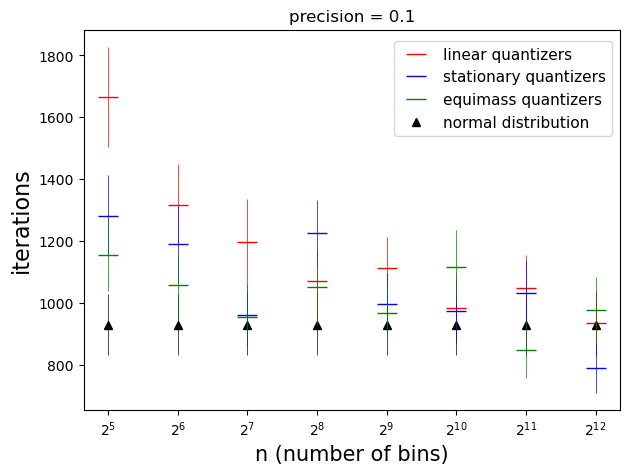

In [132]:
f1 = plt.figure(1)
ax=plt.axes()

ax.plot(number_bins_list,average_iterations_linear,marker = "_",label='linear quantizers',markersize=15, linewidth = 0, color = 'red')
ax.plot(number_bins_list,average_iterations_stationary,marker = "_",label='stationary quantizers',markersize=15, linewidth = 0, color = 'blue')
ax.plot(number_bins_list,average_iterations_equimass,marker = "_",label='equimass quantizers',markersize=15, linewidth = 0, color = 'green')
ax.plot(number_bins_list,[average_iterations_normal]*len(number_bins_list),marker = "^",label='normal distribution',markersize=6, linewidth = 0, color = 'black')


ax.errorbar(number_bins_list,[average_iterations_normal]*len(number_bins_list),
               xerr=0,
               yerr= [standard_error_iterations]*len(number_bins_list),
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'black')

ax.errorbar(number_bins_list,average_iterations_linear,
               xerr=0,
               yerr= standard_error_iterations_linear,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'red')
ax.errorbar(number_bins_list,average_iterations_stationary,
               xerr=0,
               yerr= standard_error_iterations_stationary,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'blue')

ax.errorbar(number_bins_list,average_iterations_equimass,
               xerr=0,
               yerr= standard_error_iterations_equimass,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'green')


ax.set_ylabel('iterations',fontsize=16)
ax.set_xlabel('n (number of bins)',fontsize=15)
plt.title("precision = " + str(precision))
plt.tight_layout()
plt.xscale('log', base=2)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.7),fontsize=11)

f1.savefig('iterations_MH_comparisons.pdf')
plt.show()

# Comparisons: mean reversion rate "a"

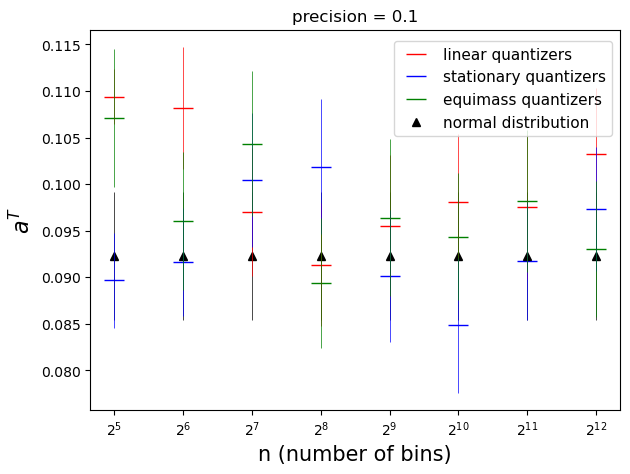

In [140]:
f2 = plt.figure(1)
ax=plt.axes()

ax.plot(number_bins_list,average_a_linear,marker = "_",label='linear quantizers',markersize=15, linewidth = 0, color = 'red')
ax.plot(number_bins_list,average_a_stationary,marker = "_",label='stationary quantizers',markersize=15, linewidth = 0, color = 'blue')
ax.plot(number_bins_list,average_a_equimass,marker = "_",label='equimass quantizers',markersize=15, linewidth = 0, color = 'green')
ax.plot(number_bins_list,[average_a]*len(number_bins_list),marker = "^",label='normal distribution',markersize=6, linewidth = 0, color = 'black')


ax.errorbar(number_bins_list,[average_a]*len(number_bins_list),
               xerr=0,
               yerr= [standard_error_a]*len(number_bins_list),
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'black')

ax.errorbar(number_bins_list,average_a_linear,
               xerr=0,
               yerr= standard_error_a_linear,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'red')
ax.errorbar(number_bins_list,average_a_stationary,
               xerr=0,
               yerr= standard_error_a_stationary,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'blue')

ax.errorbar(number_bins_list,average_a_equimass,
               xerr=0,
               yerr= standard_error_a_equimass,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'green')


ax.set_ylabel(r'$a^T$',fontsize=16)
ax.set_xlabel('n (number of bins)',fontsize=15)
plt.title("precision = " + str(precision))
plt.tight_layout()
plt.xscale('log', base=2)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.7),fontsize=11)
f2.savefig('mean_reversion_MH_comparisons.pdf')

plt.show()

# Comparisons: mean reversion rate of the stochastic component,  "b"

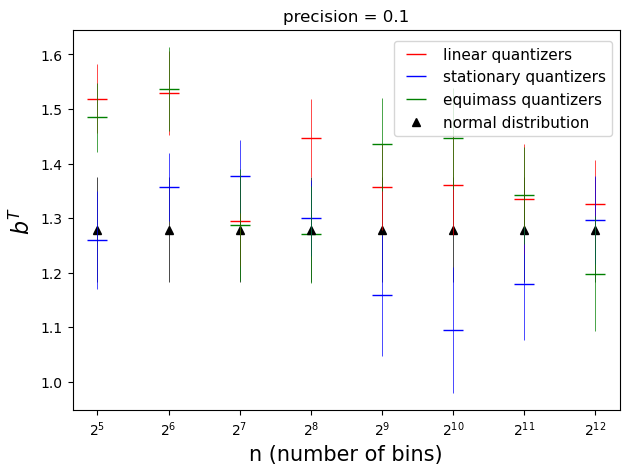

In [134]:
f2 = plt.figure(1)
ax=plt.axes()

ax.plot(number_bins_list,average_b_linear,marker = "_",label='linear quantizers',markersize=15, linewidth = 0, color = 'red')
ax.plot(number_bins_list,average_b_stationary,marker = "_",label='stationary quantizers',markersize=15, linewidth = 0, color = 'blue')
ax.plot(number_bins_list,average_b_equimass,marker = "_",label='equimass quantizers',markersize=15, linewidth = 0, color = 'green')
ax.plot(number_bins_list,[average_b]*len(number_bins_list),marker = "^",label='normal distribution',markersize=6, linewidth = 0, color = 'black')


ax.errorbar(number_bins_list,[average_b]*len(number_bins_list),
               xerr=0,
               yerr= [standard_error_b]*len(number_bins_list),
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'black')

ax.errorbar(number_bins_list,average_b_linear,
               xerr=0,
               yerr= standard_error_b_linear,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'red')
ax.errorbar(number_bins_list,average_b_stationary,
               xerr=0,
               yerr= standard_error_b_stationary,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'blue')

ax.errorbar(number_bins_list,average_b_equimass,
               xerr=0,
               yerr= standard_error_b_equimass,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'green')


ax.set_ylabel(r'$b^T$',fontsize=16)
ax.set_xlabel('n (number of bins)',fontsize=15)
plt.title("precision = " + str(precision))
plt.tight_layout()
plt.xscale('log', base=2)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.7),fontsize=11)

plt.show()

# Comparisons: spot curve of rate "theta"

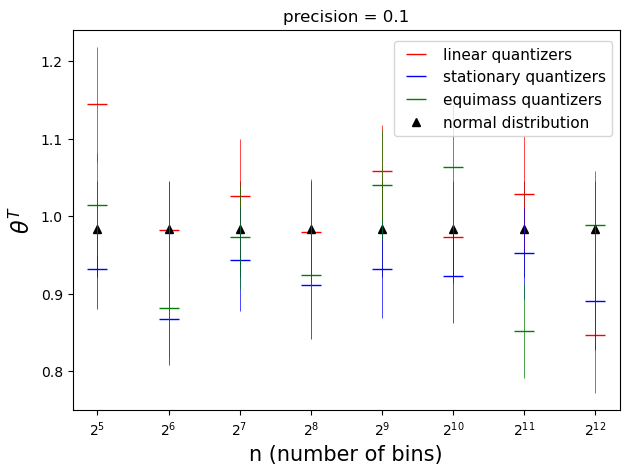

In [135]:
f2 = plt.figure(1)
ax=plt.axes()

ax.plot(number_bins_list,average_theta_linear,marker = "_",label='linear quantizers',markersize=15, linewidth = 0, color = 'red')
ax.plot(number_bins_list,average_theta_stationary,marker = "_",label='stationary quantizers',markersize=15, linewidth = 0, color = 'blue')
ax.plot(number_bins_list,average_theta_equimass,marker = "_",label='equimass quantizers',markersize=15, linewidth = 0, color = 'green')
ax.plot(number_bins_list,[average_theta]*len(number_bins_list),marker = "^",label='normal distribution',markersize=6, linewidth = 0, color = 'black')


ax.errorbar(number_bins_list,[average_theta]*len(number_bins_list),
               xerr=0,
               yerr= [standard_error_theta]*len(number_bins_list),
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'black')

ax.errorbar(number_bins_list,average_theta_linear,
               xerr=0,
               yerr= standard_error_theta_linear,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'red')
ax.errorbar(number_bins_list,average_theta_stationary,
               xerr=0,
               yerr= standard_error_theta_stationary,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'blue')

ax.errorbar(number_bins_list,average_theta_equimass,
               xerr=0,
               yerr= standard_error_theta_equimass,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'green')


ax.set_ylabel(r'$\theta^T$',fontsize=16)
ax.set_xlabel('n (number of bins)',fontsize=15)
plt.title("precision = " + str(precision))
plt.tight_layout()
plt.xscale('log', base=2)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.7),fontsize=11)

plt.show()

# Comparisons: volatility of rate, "sigma1"

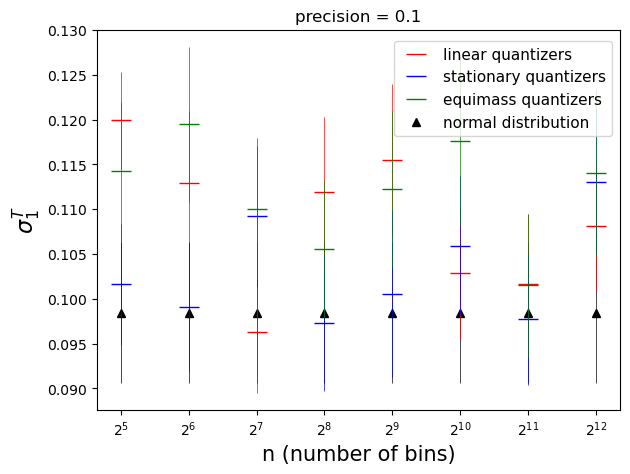

In [136]:
f2 = plt.figure(1)
ax=plt.axes()

ax.plot(number_bins_list,average_sigma1_linear,marker = "_",label='linear quantizers',markersize=15, linewidth = 0, color = 'red')
ax.plot(number_bins_list,average_sigma1_stationary,marker = "_",label='stationary quantizers',markersize=15, linewidth = 0, color = 'blue')
ax.plot(number_bins_list,average_sigma1_equimass,marker = "_",label='equimass quantizers',markersize=15, linewidth = 0, color = 'green')
ax.plot(number_bins_list,[average_sigma1]*len(number_bins_list),marker = "^",label='normal distribution',markersize=6, linewidth = 0, color = 'black')


ax.errorbar(number_bins_list,[average_sigma1]*len(number_bins_list),
               xerr=0,
               yerr= [standard_error_sigma1]*len(number_bins_list),
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'black')

ax.errorbar(number_bins_list,average_sigma1_linear,
               xerr=0,
               yerr= standard_error_sigma1_linear,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'red')
ax.errorbar(number_bins_list,average_sigma1_stationary,
               xerr=0,
               yerr= standard_error_sigma1_stationary,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'blue')

ax.errorbar(number_bins_list,average_sigma1_equimass,
               xerr=0,
               yerr= standard_error_sigma1_equimass,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'green')


ax.set_ylabel(r'$\sigma^{T}_{1}$',fontsize=16)
ax.set_xlabel('n (number of bins)',fontsize=15)
plt.title("precision = " + str(precision))
plt.tight_layout()
plt.xscale('log', base=2)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.7),fontsize=11)

plt.show()

# Comparisons: volatility of stochastic component of rate, "sigma2"

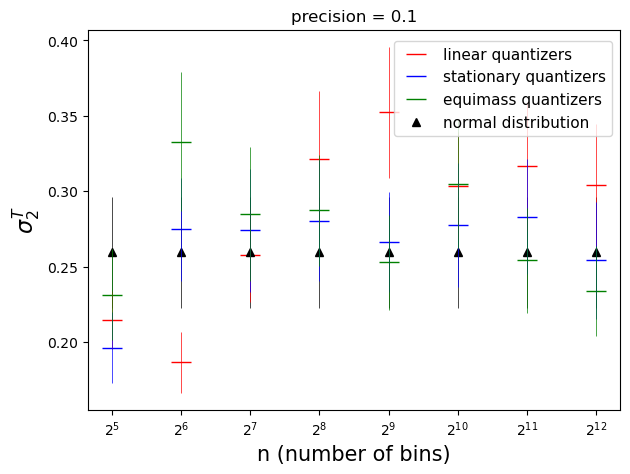

In [137]:
f2 = plt.figure(1)
ax=plt.axes()

ax.plot(number_bins_list,average_sigma2_linear,marker = "_",label='linear quantizers',markersize=15, linewidth = 0, color = 'red')
ax.plot(number_bins_list,average_sigma2_stationary,marker = "_",label='stationary quantizers',markersize=15, linewidth = 0, color = 'blue')
ax.plot(number_bins_list,average_sigma2_equimass,marker = "_",label='equimass quantizers',markersize=15, linewidth = 0, color = 'green')
ax.plot(number_bins_list,[average_sigma2]*len(number_bins_list),marker = "^",label='normal distribution',markersize=6, linewidth = 0, color = 'black')


ax.errorbar(number_bins_list,[average_sigma2]*len(number_bins_list),
               xerr=0,
               yerr= [standard_error_sigma2]*len(number_bins_list),
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'black')

ax.errorbar(number_bins_list,average_sigma2_linear,
               xerr=0,
               yerr= standard_error_sigma2_linear,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'red')
ax.errorbar(number_bins_list,average_sigma2_stationary,
               xerr=0,
               yerr= standard_error_sigma2_stationary,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'blue')

ax.errorbar(number_bins_list,average_sigma2_equimass,
               xerr=0,
               yerr= standard_error_sigma2_equimass,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'green')


ax.set_ylabel(r'$\sigma^{T}_{2}$',fontsize=16)
ax.set_xlabel('n (number of bins)',fontsize=15)
plt.title("precision = " + str(precision))
plt.tight_layout()
plt.xscale('log', base=2)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.7),fontsize=11)

plt.show()

# Comparisons: correlation parameter "rho"

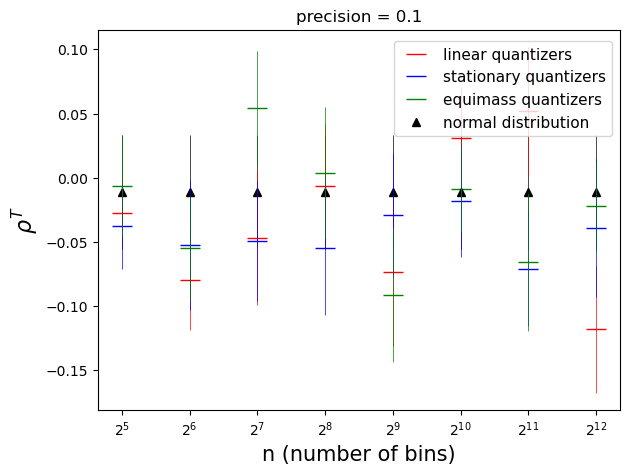

In [138]:
f2 = plt.figure(1)
ax=plt.axes()

ax.plot(number_bins_list,average_rho_linear,marker = "_",label='linear quantizers',markersize=15, linewidth = 0, color = 'red')
ax.plot(number_bins_list,average_rho_stationary,marker = "_",label='stationary quantizers',markersize=15, linewidth = 0, color = 'blue')
ax.plot(number_bins_list,average_rho_equimass,marker = "_",label='equimass quantizers',markersize=15, linewidth = 0, color = 'green')
ax.plot(number_bins_list,[average_rho]*len(number_bins_list),marker = "^",label='normal distribution',markersize=6, linewidth = 0, color = 'black')


ax.errorbar(number_bins_list,[average_rho]*len(number_bins_list),
               xerr=0,
               yerr= [standard_error_rho]*len(number_bins_list),
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'black')

ax.errorbar(number_bins_list,average_rho_linear,
               xerr=0,
               yerr= standard_error_rho_linear,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'red')
ax.errorbar(number_bins_list,average_rho_stationary,
               xerr=0,
               yerr= standard_error_rho_stationary,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'blue')

ax.errorbar(number_bins_list,average_rho_equimass,
               xerr=0,
               yerr= standard_error_rho_equimass,
               fmt='none',
               elinewidth = 0.5,
               ecolor = 'green')


ax.set_ylabel(r'$\rho^{T}$',fontsize=16)
ax.set_xlabel('n (number of bins)',fontsize=15)
plt.title("precision = " + str(precision))
plt.tight_layout()
plt.xscale('log', base=2)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.7),fontsize=11)

plt.show()

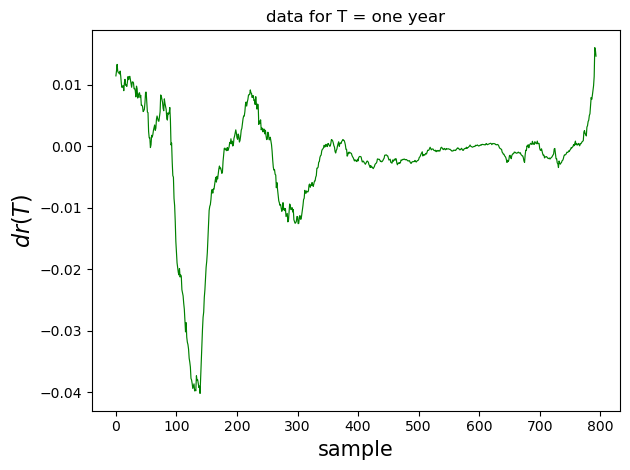

In [260]:
### Rate plots ###

samples = [x for x in range(0,len(data_yearly))]

fdata = plt.figure(1)
ax_data=plt.axes()

ax_data.plot(samples, data_yearly, linewidth=0.85, color = 'green')

ax_data.set_ylabel(r'$dr(T)$',fontsize=16)
ax_data.set_xlabel('sample',fontsize=15)
plt.title("data for T = one year")
plt.tight_layout()

plt.show()


# Backtesting

In [139]:
### Backtesting ###

n = len(data_yearly)

# Normal distribution sampling

dr_list.sort() # sort from smallest to largest value

index_99 = round(0.99*n) # index of 99th percentile
percentile_99 = dr_list[index_99 + 1]

index_1 = round(0.01*n) # index of 1st percentile
percentile_1 = dr_list[index_1 + 1]


count_above_99 = 0
count_below_1 = 0

for index in range(0,n):
    
    if data_yearly[index] >= percentile_99:
        
        count_above_99 = count_above_99 + 1
    
    if data_yearly[index] <= percentile_1:
        
        count_below_1 = count_below_1 + 1
        
        
        
# Linear optimizers sampling

count_above_99_linear = []
count_below_1_linear = []

for index_bins in range(0,len(number_bins_list)):
    
    dr_list_linear[index_bins].sort() # sort from smallest to largest value
    
    index_99 = round(0.99*n) # index of 99th percentile
    percentile_99 = dr_list_linear[index_bins][index_99 + 1]

    index_1 = round(0.01*n) # index of 1st percentile
    percentile_1 = dr_list_linear[index_bins][index_1 + 1]
    
    count_above_99 = 0
    count_below_1 = 0

    for index in range(0,n):
    
        if data_yearly[index] >= percentile_99:
        
            count_above_99 = count_above_99 + 1
    
        if data_yearly[index] <= percentile_1:
        
            count_below_1 = count_below_1 + 1
            
    count_above_99_linear.append(count_above_99)
    count_below_1_linear.append(count_below_1)
    
    
# Stationary optimizers sampling

count_above_99_stationary = []
count_below_1_stationary = []

for index_bins in range(0,len(number_bins_list)):
    
    dr_list_stationary[index_bins].sort() # sort from smallest to largest value
    
    index_99 = round(0.99*n) # index of 99th percentile
    percentile_99 = dr_list_stationary[index_bins][index_99 + 1]

    index_1 = round(0.01*n) # index of 1st percentile
    percentile_1 = dr_list_stationary[index_bins][index_1 + 1]
    
    count_above_99 = 0
    count_below_1 = 0

    for index in range(0,n):
    
        if data_yearly[index] >= percentile_99:
        
            count_above_99 = count_above_99 + 1
    
        if data_yearly[index] <= percentile_1:
        
            count_below_1 = count_below_1 + 1
            
    count_above_99_stationary.append(count_above_99)
    count_below_1_stationary.append(count_below_1)
    
    
# Equimass optimizers sampling

count_above_99_equimass = []
count_below_1_equimass = []

for index_bins in range(0,len(number_bins_list)):
    
    dr_list_equimass[index_bins].sort() # sort from smallest to largest value
    
    index_99 = round(0.99*n) # index of 99th percentile
    percentile_99 = dr_list_equimass[index_bins][index_99 + 1]

    index_1 = round(0.01*n) # index of 1st percentile
    percentile_1 = dr_list_equimass[index_bins][index_1 + 1]
    
    count_above_99 = 0
    count_below_1 = 0

    for index in range(0,n):
    
        if data_yearly[index] >= percentile_99:
        
            count_above_99 = count_above_99 + 1
    
        if data_yearly[index] <= percentile_1:
        
            count_below_1 = count_below_1 + 1
            
    count_above_99_equimass.append(count_above_99)
    count_below_1_equimass.append(count_below_1)